## Prueba Tecnica: Mineria de contrastes

### Descripcion del proyecto 

El proyecto consiste en implemtar un flujo de mineria de datos sobre un conjunto de datos con informacion salarial de una orgalizacion. 

Para este proyecto haremos uso de la tecnica llamada `Mineria de contrastes (Contrast Set Mining, CSM), esta es una tecnica de mineria de datos con el proposito de encontrar conjuntos de caracteristicas que señalen diferencias significativas entre grupos. 

### Pasos del proyecto

- Analisis exploratorio de datos: Plantearemos una descripcion exploratoria del conjunto de datos, incluyendo almenos dos visualziaciones de datos.
  
- Pre-procesamiento de datos: La mineria de contrastes trata con datos exclusivamente categoricos, por lo que es necesario aplicar alguna tecnica de transformacion de datos para convertir las variables numericas en variables categoricas

- Mineria de contrastes: Implementa un algoritmo de mineria de contrastes que recupere todos los conjuntos de contraste en los datos proporcionados. Ejecute el algoritmo una vez por cada variable del conjunto de datos, tomandola como variable de grupo. 

#### Descripcion de los datos

##### Caracteristicas

- `JobTitle`: El puesto al cual pertenece.

- `Gender`: Sexo.

- `Age`: Edad.

- `PerfEval`: Rendimiento de evaluacion del 1 al 5 donde 1 es el minimo y 5 es el maximo. 

- `Edu`: Nivel de educacion.

- `Dept`: Area / Departamento de trabajo.

- `Seniority`: antigüedad / Maestria del puesto.
  
- `BasePay`: Sueldo base.

- `Bonus`: Bonos de salario. 

### Antecedentes

Para que un conjunto de contraste sea `viable` es neceario cumplir con los siguientes criterios:

- `Grande`: El conjunto de contraste debe superar la desviacion minima. 
  
- `Significativo`: La asociacion entre la variable de grupo y el conjunto de contraste debe ser estadisticamente significativa. para determinar esto es necesario aplicar la prueba estadistica `chi2` a una tabla con contingencia donde las filas son la pertenencia al conjunto de contraste y las columnas son grupos. Use `0.05` como umbral para completar el `p-value`.
  
- `Productivo`: Un conjunto de contraste es productivo si todos sus subconjuntos propios son tambien conjuntos de contraste viables.  


Justifique su eleccion de valor `MINDEV`  

#### Importamos librerias.

Vamos principalmente a utilizar:
- `pandas` para la manipulacion de datos.
  
- `seaborn` para la creacion de graficos y `matplotlib` para complemetar los graficos. 
- `scipy` para realizar test de hipotesis.

In [392]:
### importamos librerias

import pandas as pd
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


#### Carga de datos 

tenemos solamente un dataset descrito anteriormente el cual tenemos en el mismo proyecto en formato CSV.



In [393]:
# carga de datos

try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('datasets/data.csv')
    

#### Exploracion inicial de datos

Esta exploracion nos ayuda a darnos una idea inicial de:

- Las columnas que tenemos
  
- Observar el tipo de infromacion que contiene
- El tipo de datos que contiene
- Si es que tenemos valores ausentes
- Detectar valores atipicos de manera rapida

In [394]:
### exploracion inicial de datos

data.head()


,jobTitle,gender,age,perfEval,edu,dept,seniority,basePay,bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319


In [395]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   jobTitle   1000 non-null   object
 1   gender     1000 non-null   object
 2   age        1000 non-null   int64 
 3   perfEval   1000 non-null   int64 
 4   edu        1000 non-null   object
 5   dept       1000 non-null   object
 6   seniority  1000 non-null   int64 
 7   basePay    1000 non-null   int64 
 8   bonus      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


In [396]:
data.describe()

,age,perfEval,seniority,basePay,bonus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.393000,3.037000,2.971000,94472.653000,6467.161000
std,14.294856,1.423959,1.395029,25337.493272,2004.377365
min,18.000000,1.000000,1.000000,34208.000000,1703.000000
25%,29.000000,2.000000,2.000000,76850.250000,4849.500000
50%,41.000000,3.000000,3.000000,93327.500000,6507.000000
75%,54.250000,4.000000,4.000000,111558.000000,8026.000000
max,65.000000,5.000000,5.000000,179726.000000,11293.000000


##### Conclusiones exploracion incial. 

- No tenemos valores ausentes los cuales deban ser tratados
  
- Todos los tipos de datos hacen sentido al nombre e la columna y su contenido 

Respecto a las siguentes columnas:
  
- `Age`: tenemos valores maximo y minimos logicos que van de `18` a `65` 
  
- `perfEval` y `seniority` se mantiene en el rango de `1` a `5` ya que son las unicas calificaciones existentes
  
- `basePay` y `bonus` hacen sentido a los sueldos de las profesiones mencioandas.

#### Feature Engineering

Vamos a crear tres nuevas columnas debido a que debemos volver categoricas las variables lineales como `age` y `basePay` / `bonus` , adicional nos aportara otra perspectiva de los datos.

- `total_salary`  la cual sera la suma de `basePay` y `bonus` 

- `total_salary_range` es la agrupacion de `total_salary` para volver categorica una variable continua.

- `age_group` es la agrupacion de `age` para volver categorica una variable continua.

De igual modo renombraremos las columnas para aplicar mejores practicas de codigo como:

- Separar las palabras con un "_" 

- Convertir todas las letras a minusculas

In [397]:
### renombramos las columnas 

data = data.rename(columns={'jobTitle':'job_title','perfEval':'perf_eval','basePay':'base_pay'})

In [398]:
data['total_salary'] = data['base_pay'] + data['bonus']

In [399]:
### rendimiento relativo 

In [400]:
## creacion de grupos para la exploracion de datos

# función que calcule la categoría de edad
def assing_age_range(age):
    if age < 0 or pd.isna(age):
        return 'NA'
    elif age < 20:
        return '0-19'
    elif age < 40:
        return '20-39'
    elif age < 60:
        return '40-59'
    elif age >= 60:
        return '60+'


In [401]:
# función que calcule la categoría de ingresos

def total_salary_range(salary):
    if salary < 40000 or pd.isna(salary):
        return '< 40,000'
    elif salary < 80001:
        return '40,000-80,000'
    elif salary < 120001:
        return '80,001-120,000'
    elif salary < 160001:
        return '120,001-160,000'
    elif salary >= 160001:
        return '> 160,000'

In [402]:

data['total_salary_range'] = data['total_salary'].apply(total_salary_range)
data['age_group'] = data['age'].apply(assing_age_range)
data.head()


,job_title,gender,age,perf_eval,edu,dept,seniority,base_pay,bonus,total_salary,total_salary_range,age_group
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938,52301,"40,000-80,000",0-19
1,Software Engineer,Male,21,5,College,Management,5,108476,11128,119604,"80,001-120,000",20-39
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268,99476,"80,001-120,000",0-19
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154,118234,"80,001-120,000",20-39
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319,108783,"80,001-120,000",20-39


### Analisis exploratorio de datos

Esta seccion se dividira en tres partes

1. Establecimiento de `variables` como los colores que se utilizaran asi como la creacion de `funciones` para hacer un reporte con mejor codigo, mas limpio.
   
2. Exploracion de datos `univariado`, en el cual se explorara cada variable individaualmente.
3. Exploracion de datos `bivariado`, en el cual se exporaran variables contrastandolas con otras variables.
4. Exploracion de `relacion entre variables`, lo cual nos dara una idea del comportamiento de los colaboradores en la institucion.

#### Establecimiento de variables y funciones.

In [403]:
## establecemos paletas de colores a usar

paleta = ['#a1c9f4', '#ffffff', '#ffb482']
contraste=['#a1c9f4','#ffb482']

In [404]:
###  Funcion para grafico de barras

def barras(columna,color):
    df = data[columna].value_counts().reset_index()
    df.columns = [columna, 'colaboradores']

    # Configuramos el gráfico de barras
    ax = sns.barplot(x=columna, y='colaboradores', data=df, edgecolor='black', palette=color)

    # Agregamos el conteo en cada barra
    for index, row in df.iterrows():
        ax.text(index, row['colaboradores'], row['colaboradores'], ha='center', va='bottom')

    # Configuramos los ejes y el título
    plt.xlabel(f"{columna}")
    plt.ylabel("Cantidad de colaboradores")
    plt.xticks(rotation=-45, horizontalalignment='left')
    plt.title(f"Cantidad de colaboradores por {columna}")

    # Mostramos el gráfico
    plt.show()

In [405]:
### Funcion para boxplot

def boxp(columnax,columnay,color):
    boxprops = {'edgecolor': 'black', 'linewidth': 1.5}

    fig, ax = plt.subplots(figsize=(7, 5))

    sns.boxplot(x=columnax, y=columnay, data=data, palette=color, boxprops=boxprops)

    plt.xlabel(f"{columnax}")
    plt.ylabel("Salario")
    plt.xticks(rotation=-45, horizontalalignment='left')
    plt.title(f"Rango de salario por {columnax}")
    plt.show()

#### Exploracion de datos univariable 



##### Caracteristicas principales de los `roles de trabajo`

Podemos observar uniformidad entre los roles de la empresa en un rango de `90` a `118` colaboradores donde.

Asi como podriamos concluir que por las caracteriticas de los puestos esta es una empresa que vende algun producto el cual debe ser almacenado y enviado pero con un gran enfoque a lo tecnologico por la gran cantidad de puestos como `ingeniero de software` y `data scientist` , muy probablemente se trata de un `E-comerce`.

Otros datos a destacar:

- Titulo con mas colaboradores: `Marketing Associate`
  
- Titulo con menos colaboradores: `Manager` 


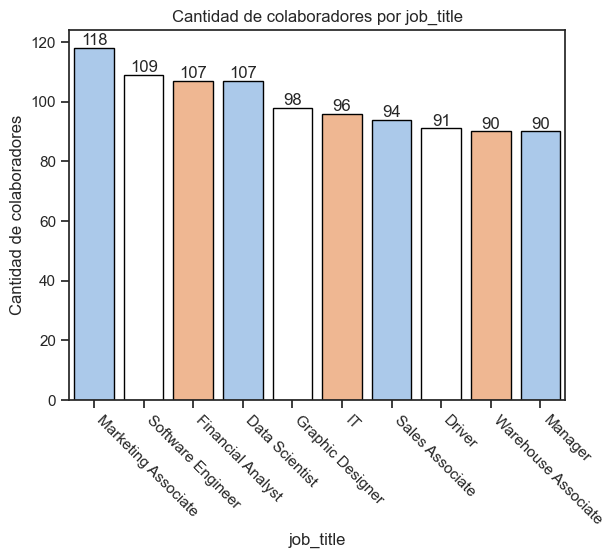

In [406]:
barras('job_title',paleta)

##### Caracteristicas principales de la distribucion de `generos` en al empresa.

Podemos observar uniformidad entre los generos de la empresa con una variacion de `64` colaboradores entre grupos, por lo cual se consideraria `balanceado`.

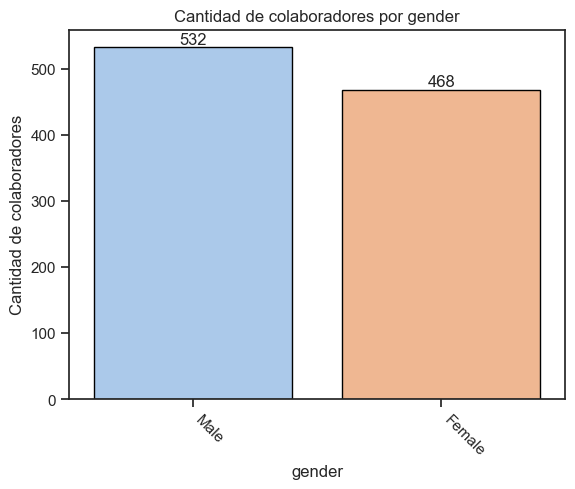

In [407]:
barras('gender',contraste)

##### Caracteristicas principales de las `edades`

Podemos observar uniformidad entre las edades en la empresa con picos alrededor de `18`, `33`, `37`, `48` y `62` años.

Asi como podriamos destacar valles en `26`, `35` y `49` años. 

Otros datos a destacar:

- Edad minima: `18 años`
  
- Mediana de edad: `41 años` 

- Edad maxima: `65 años`

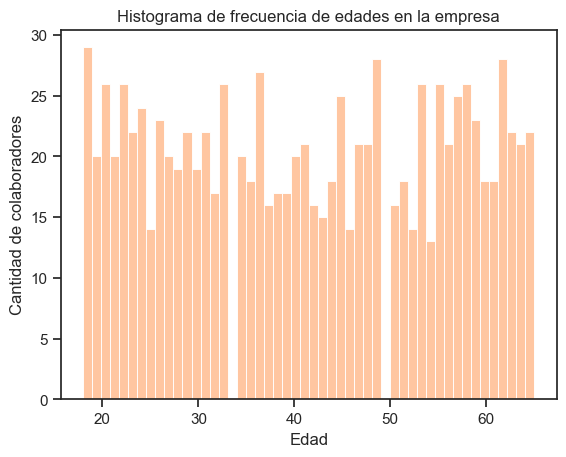

In [408]:
(
    sns.histplot(data=data['age'], bins=50, color='#ffb482')
    .set(title='Histograma de frecuencia de edades en la empresa', 
            xlabel='Edad', 
            ylabel='Cantidad de colaboradores')
)
plt.show()

##### Caracteristicas principales de los `sueldos base` y `bonos anuales`. 

Podemos observar una `distribucion normal` para ambos conjuntos de datos aunque ligeramente mas distribuidos en los `bonos`. 

Los rangos en los que se encuentran los sueldos base es de `$34,208` a `$17,9726` y los bonos se encontrarian en un rango de `$1,703` a `$11293`.

Otros datos a destacar:

- La mayoria de `salarios base` se encecuentra distribuido alrededor de `$80,000` y `100,000` USD
  
- La mayoria de `bonos` se encecuentra distribuido alrededor de `$4,000` y `$9,000` USD


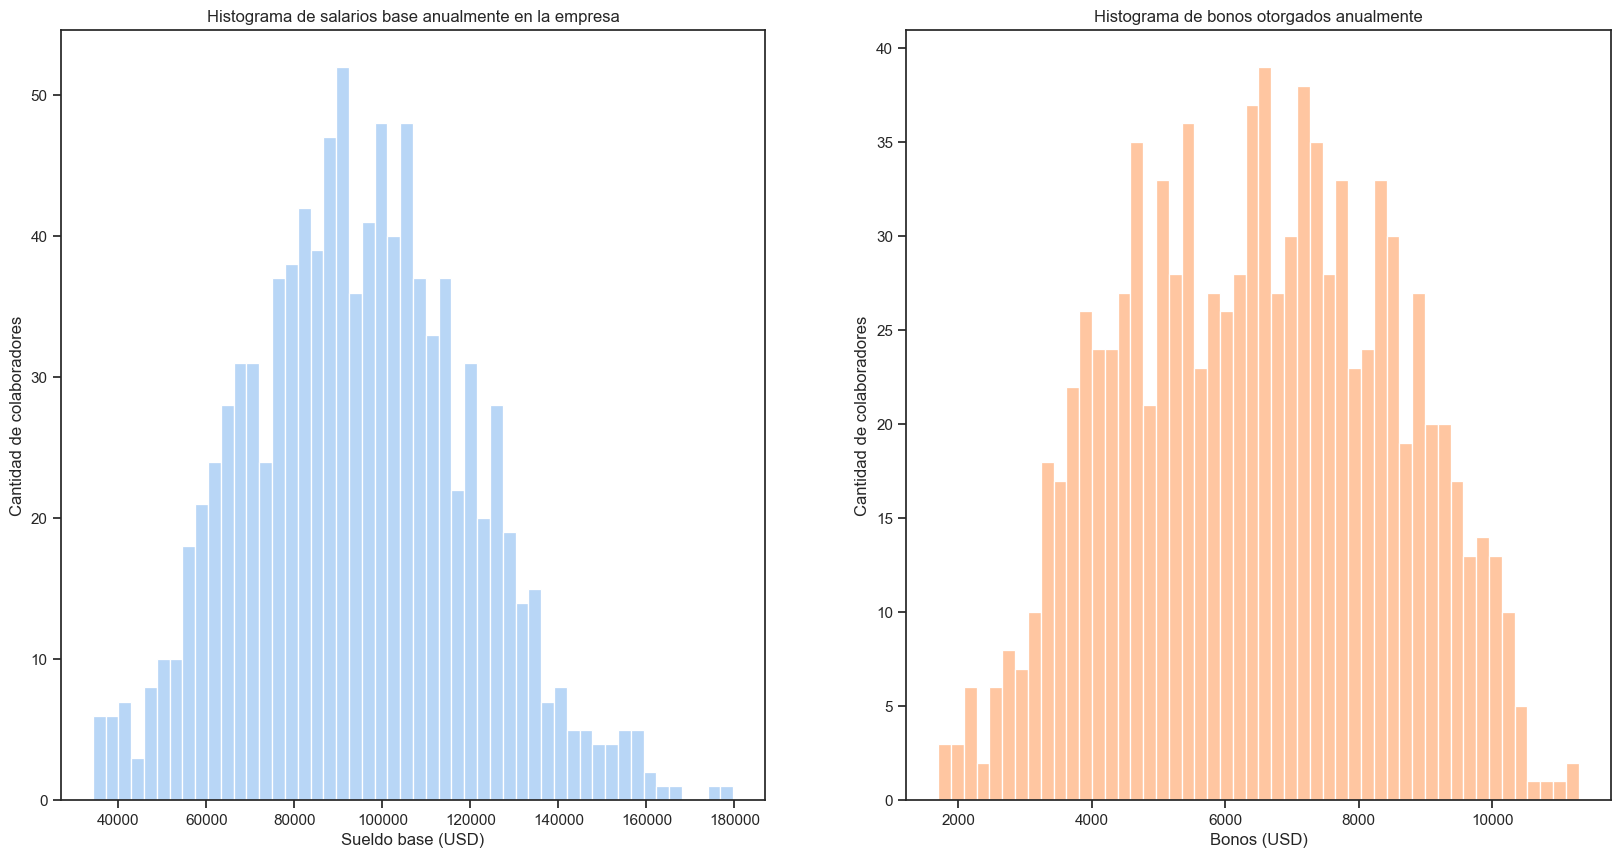

In [409]:
# subplots para salarios y bonos

fig, axes = plt.subplots(1, 2, figsize=(20,10))

# plotear el histograma en cada subplot
sns.histplot(ax=axes[0], data=data['base_pay'], bins=50, color='#a1c9f4')
sns.histplot(ax=axes[1], data=data['bonus'], bins=50, color='#ffb482')

# configurar los detalles de los subplots
axes[0].set(title='Histograma de salarios base anualmente en la empresa', xlabel='Sueldo base (USD)', ylabel='Cantidad de colaboradores')
axes[1].set(title='Histograma de bonos otorgados anualmente', xlabel='Bonos (USD)', ylabel='Cantidad de colaboradores')

# ajustar la distancia entre los subplots
#plt.tight_layout()

# mostrar los subplots
plt.show()


##### Caracteristicas principales de los `desempeño de evaluacion` y `seniority`. 

Podemos observar una `uniformidad` para ambos conjuntos de datos.

Para la nota de evaluacion podemos destacar:

- La mayoria de resultados se muestran en las calificaciones 4 y 5 lo que nos dice que la empresa tiene un buen desempleño en general por parte de los colaboradores
  

Para la etiqueta de seniority:

- La `mayoria` de colaboradores se encuentran en un nivel `mid/medio`.
  
- La `menor` parte de colaboradores se encuentrane un nivel `semi senior` y hay un poco mas en un `nivel senior`.

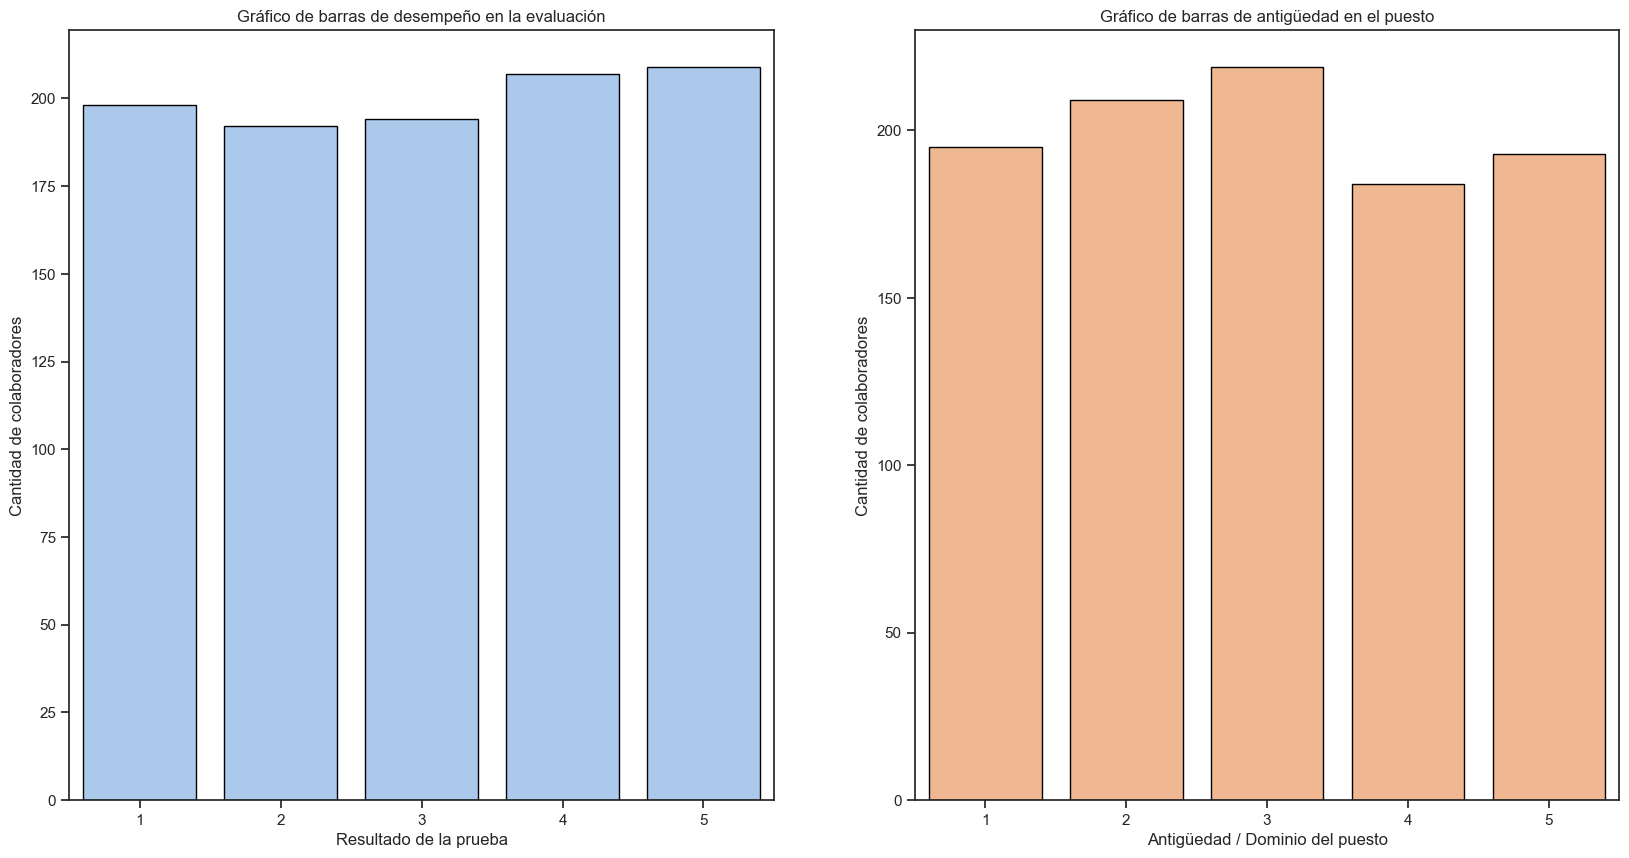

In [422]:
# Características de performance y antiguedad

# Crear subplots para los gráficos de barras
fig, axes = plt.subplots(1, 2, figsize=(20,10))

# Graficar los datos como gráficos de barras en cada subplot
sns.countplot(ax=axes[0], data=data, x='perf_eval', color='#a1c9f4', edgecolor='black')
sns.countplot(ax=axes[1], data=data, x='seniority', color='#ffb482', edgecolor='black')

# Configurar los detalles de los subplots
axes[0].set(title='Gráfico de barras de desempeño en la evaluación', xlabel='Resultado de la prueba', ylabel='Cantidad de colaboradores')
axes[1].set(title='Gráfico de barras de antigüedad en el puesto', xlabel='Antigüedad / Dominio del puesto', ylabel='Cantidad de colaboradores')

# Mostrar los subplots
plt.show()



##### Caracteristicas principales de los `departamentos`

Podemos observar uniformidad entre los roles de la empresa en un rango de `192` a `210` colaboradores donde.

Datos a destacar:

- Departamento con mas colaboradores: `Operations`
  
- Departamento con menos colaboradores: `Engineering` 

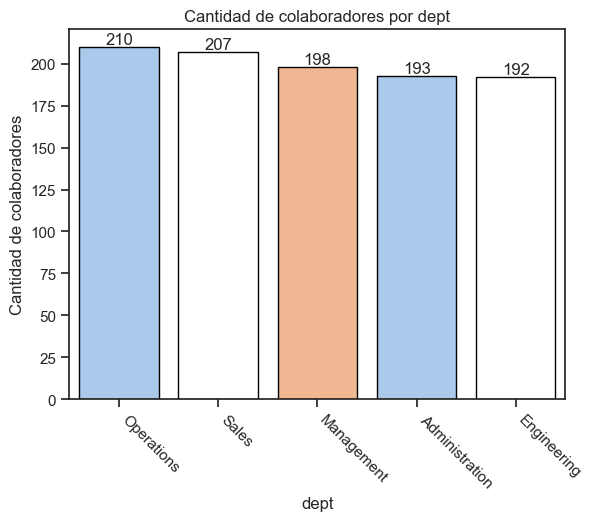

In [411]:
# departamento 

barras('dept',paleta)

### exploracion bivariada 

Para este apartado vamos a contrastar las variables contrastandolas con otras, tomaremos solo las que consideramos mas importantes como seria el `sueldo`. 

##### Caracteristicas de los `sueldos` por `role de trabajo` 

Podemos destacar que los managers se llevan la delantera en cuanto a suledos considerablemente, asi como que este es el puesto que menos se enceuntra en la empresa, los demas puestos se encuentran en un rango similar.


Otros datos a destacar:

- Solo las personas de TI tienen sueldos con valores atipicos
  
- Titulo con menor salario seria `Marketing Associate` y recordemos que es el puesto que mas se presenta en la empresa


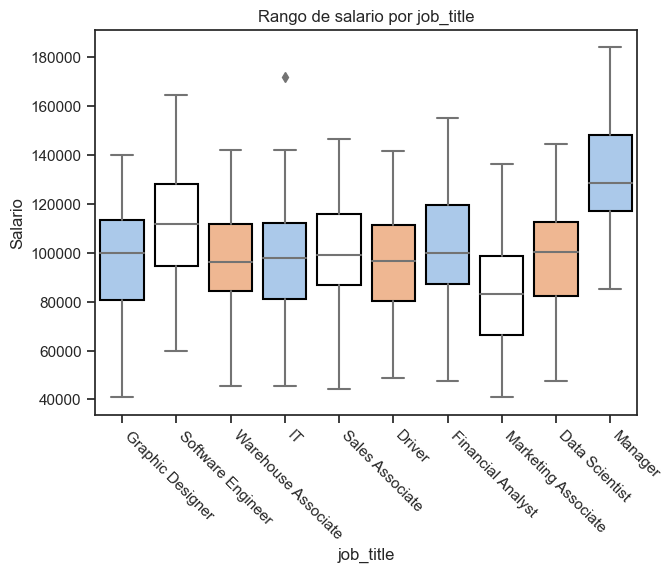

In [412]:
boxp('job_title','total_salary',paleta)

##### Caracteristicas de los `sueldos` por `role de trabajo` 

Podemos destacar que los managers se llevan la delantera en cuanto a suledos considerablemente, asi como que este es el puesto que menos se enceuntra en la empresa, los demas puestos se encuentran en un rango similar.


Otros datos a destacar:

- Solo las personas de TI tienen sueldos con valores atipicos
  
- Titulo con menor salario seria `Marketing Associate` y recordemos que es el puesto que mas se presenta en la empresa

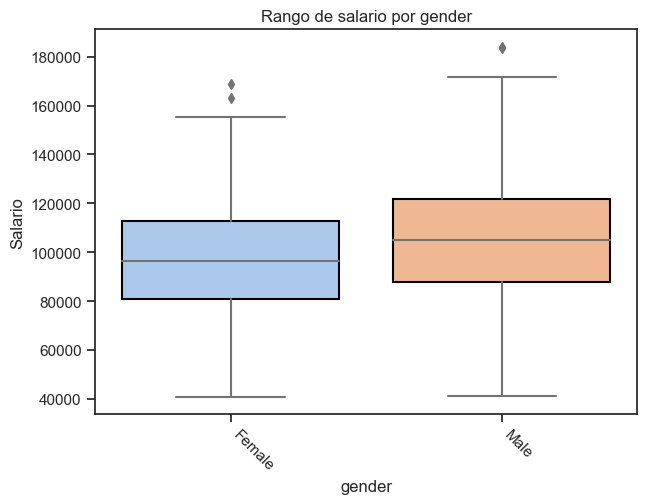

In [413]:
boxp('gender','total_salary',contraste)


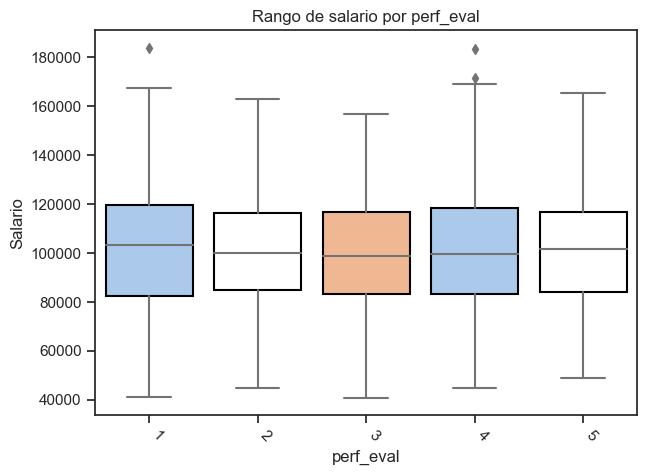

In [414]:
boxp('perf_eval','total_salary',paleta)


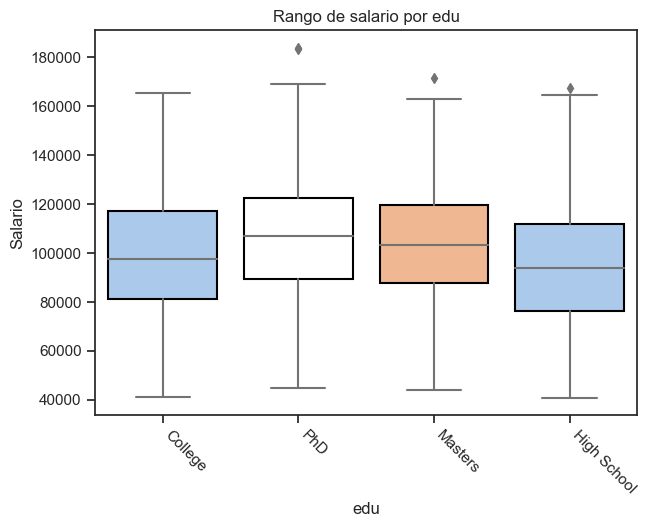

In [415]:
boxp('edu','total_salary',paleta)

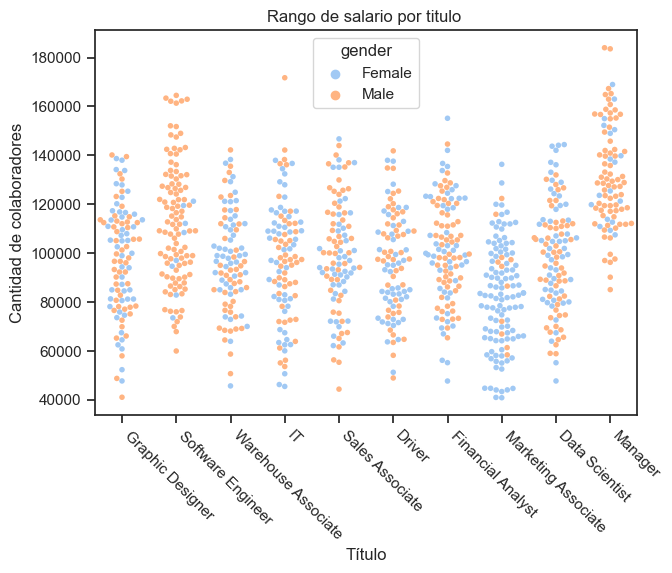

In [416]:
# Draw a categorical scatterplot to show each observation
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.swarmplot(data=data, x="job_title", y="total_salary", hue="gender", size=4,palette=contraste)
ax.set(ylabel="")

plt.xlabel("Título")
plt.ylabel("Cantidad de colaboradores")
plt.xticks(rotation=-45, horizontalalignment='left')
plt.title(f"Rango de salario por titulo ")
plt.show()

### Exploracion de correlacion

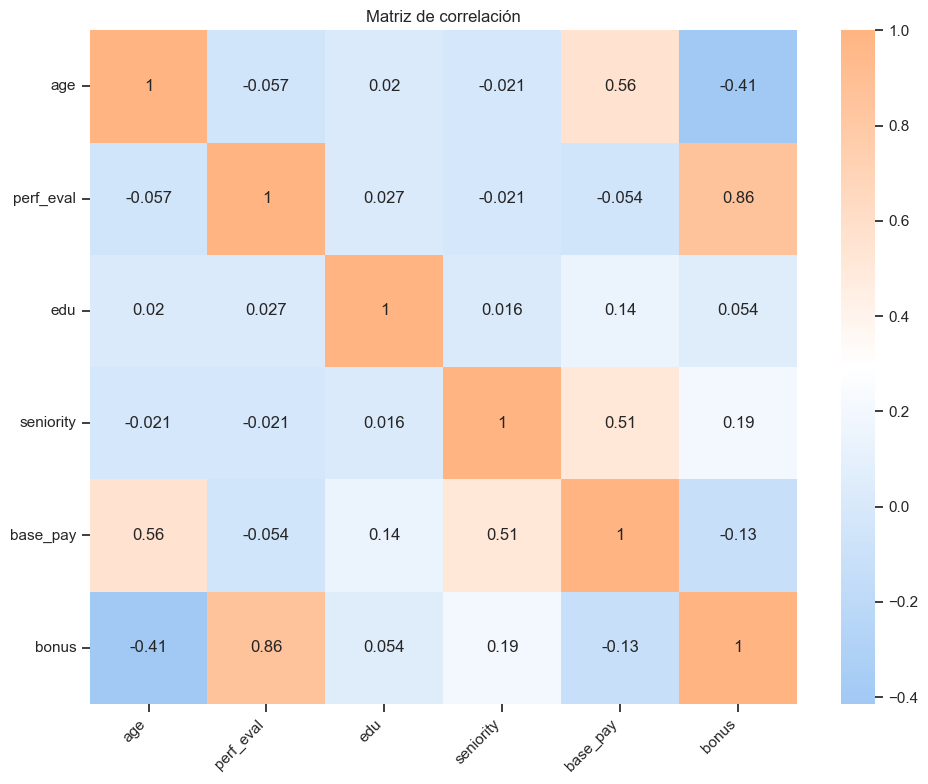

In [417]:

### Limpiamos las columnas para 

data_encoded = (
    data
    .drop(columns={'total_salary','total_salary_range','age_group'})
)


edu_dict = {'College': 0, 'High School': 1, 'Masters': 2,'PhD': 3}
data_encoded['edu'] = data_encoded['edu'].map(edu_dict)


cmap = LinearSegmentedColormap.from_list('mycmap', paleta)

corr_matrix = data_encoded.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix, cmap=cmap, annot=True, ax=ax)

plt.title("Matriz de correlación")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show() 

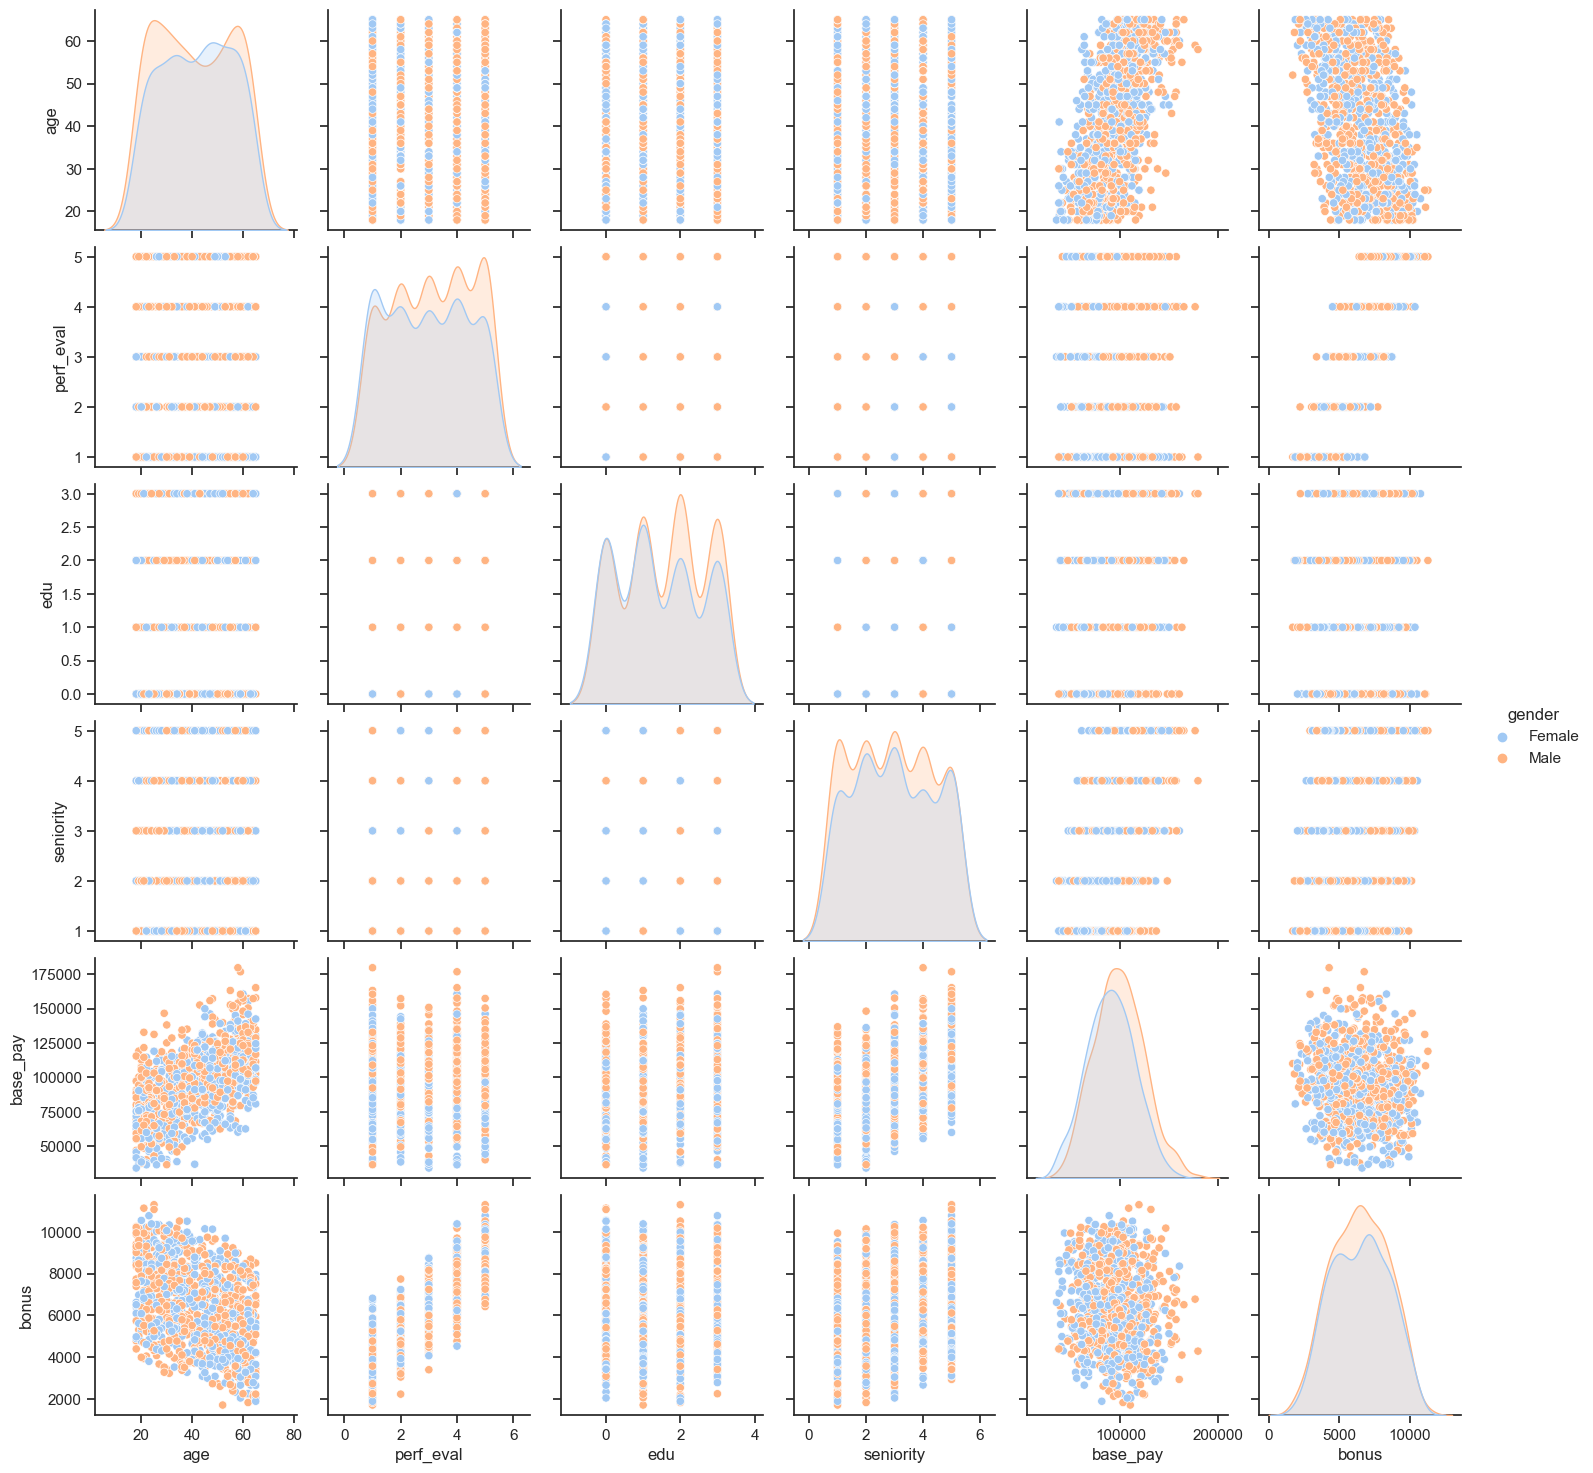

In [418]:
new_data = data[['age','base_pay','bonus','gender']]

sns.set_theme(style="ticks")
sns.pairplot(data=data_encoded, hue="gender",palette=contraste)
plt.show()

In [419]:
# El ingreso promedio de los colaboradores es igual por genero.

female = data.query('gender == "Female"')
male = data.query('gender == "Male"')

alpha = 0.05  # el nivel de significancia estadística crítica

results = st.ttest_ind(
    female['total_salary'], male['total_salary'], equal_var=False
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula, El promedio de ingresos entre generos difiere")
else:
    print("No rechazamos la hipótesis nula, El promedio de ingresos entre generos no difiere")

p-value: 7.354185839678807e-08
Rechazamos la hipótesis nula, El promedio de ingresos entre generos difiere


In [420]:
# El ingreso promedio de los manager es igual por al de los demas colaboradores.

managers = data.query('job_title == "Manager"')
others = data.query('job_title != "Manager"')

alpha = 0.05  # el nivel de significancia estadística crítica

results = st.ttest_ind(
    managers['total_salary'], others['total_salary'], equal_var=False
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula, El promedio de ingresos entre puesto difiere")
else:
    print("No rechazamos la hipótesis nula, El promedio de ingresos entre puestos no difiere")

p-value: 7.996394578042696e-27
Rechazamos la hipótesis nula, El promedio de ingresos entre puesto difiere


El p-valor (p-value) es una medida utilizada en pruebas estadísticas para evaluar la evidencia en contra de una hipótesis nula. Representa la probabilidad de obtener un resultado igual o más extremo que el observado, si la hipótesis nula es verdadera.

En el caso que mencionas, un p-value de 7.996394578042696e-27 (notación científica) indica que la probabilidad de obtener un resultado igual o más extremo que el observado bajo la hipótesis nula es extremadamente baja. En términos prácticos, es tan cercana a cero que se considera estadísticamente significativa.

En general, se utiliza un valor de corte para el p-value (llamado nivel de significancia) para decidir si se rechaza o no la hipótesis nula. Si el p-value es menor que el nivel de significancia establecido (comúnmente 0.05 o 0.01), se rechaza la hipótesis nula y se concluye que hay suficiente evidencia para respaldar la hipótesis alternativa.

`En resumen, un p-value muy pequeño, como en este caso, indica una fuerte evidencia en contra de la hipótesis nula y sugiere que existe una relación o diferencia significativa en los datos analizados.`

### Conclusiones del EDA

